## Spot price simulations

[Geometric Brownian Motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) as is assumed in the Black-Scholes model.

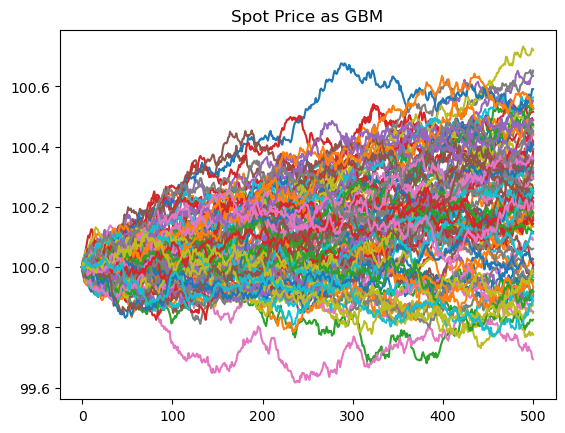

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from models.lspi import simulate_prices

num_paths = 100
plt.plot(
    np.array(
        [
            simulate_prices(starting_price=100,
                            mu=0.05,
                            sigma=0.01,
                            dt=0.0001,
                            num_steps=500) 
            for _ in range(num_paths)
        ]
    ).T
)
plt.title('Spot Price as GBM')
plt.show()

## Parameters and their influence on valuation

### European Options

In [2]:
import datetime
import options

call_options = {
    "ITM": options.EuropeanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.EuropeanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.EuropeanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ), 
} 

put_options = {
    "ITM": options.EuropeanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.EuropeanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.EuropeanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
}

#### Varying risk-free rate

In [3]:
def plot(ax, prices, xaxis, xlabel, ylabel, title):
    for (label, price) in prices:
        ax.plot(xaxis, price, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

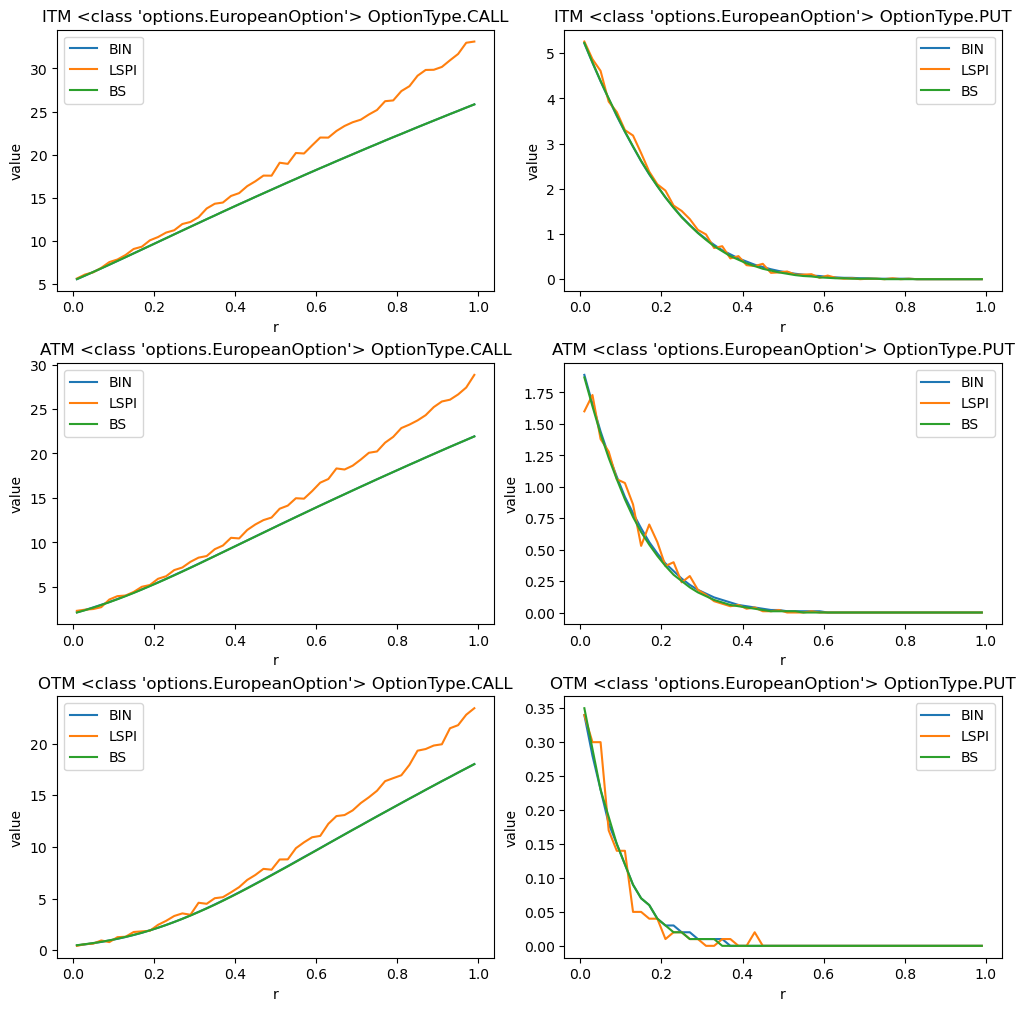

In [4]:
from models import black_scholes
from models import binomial
from models import lspi


def vary_r(call_options, put_options, r_range=np.arange(0.01, 1, 0.02)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=r, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=25) for r in r_range]
            lspi_prices = [lspi.price_option(option, risk_free_rate=r, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=25) for r in r_range]
            prices = [('BIN', bin_prices), ('LSPI', lspi_prices)]
            if isinstance(option, options.EuropeanOption):
                bs_prices = [black_scholes.price_option(option, risk_free_rate=r, volatility=0.1, time_to_maturity_in_years=3/12)[0] for r in r_range]
                prices.append(('BS', bs_prices))
            plot(ax, prices, r_range, 'r', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_r(call_options, put_options)

Notice that Binomial hugs the Black-Scholes line. This is expected as the calibrator we choose is CRR, which matches the first 2 moments of S_t: spot prices follow the same GBM. For put options, we don't seem much difference between the 3 models. However, for call options, LSPI seems to think they are worth more than what BS suggests. This is a potential trading opportunity in that, we know the expected payoff is more than the value of the option, so we buy the call option.

Also note that this is basically rho = partial derivative of V w.r.t risk-free rate. For BS model, it's given KD\*tau\*N(d2). We have D=exp(-rtau) which gives us the curve we see above. For put, it's minus tau*KD hence the opposite slope.

#### Varying implied volatility

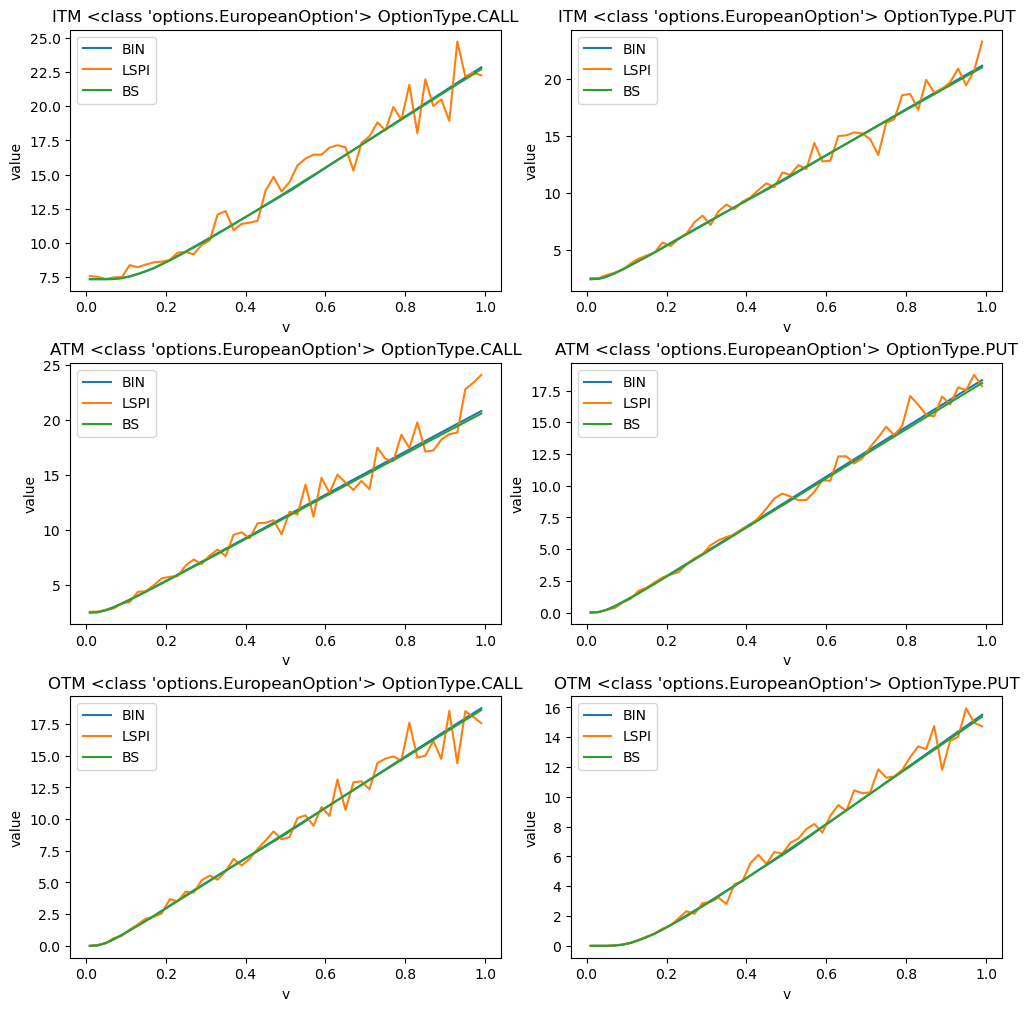

In [5]:
def vary_v(call_options, put_options, v_range=np.arange(0.01, 1, 0.02)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=0.1, volatility=v, time_to_maturity_in_years=3/12, num_steps=25) for v in v_range]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=v, time_to_maturity_in_years=3/12, num_steps=25) for v in v_range]
            
            prices = [('BIN', bin_prices), ('LSPI', lspi_prices)]
            if isinstance(option, options.EuropeanOption):
                bs_prices = [black_scholes.price_option(option, risk_free_rate=0.1, volatility=v, time_to_maturity_in_years=3/12)[0] for v in v_range]
                prices.append(('BS', bs_prices))
            plot(ax, prices, v_range, 'v', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_v(call_options, put_options)

This curve would be vega. It's the same for both call and put options, unlike delta, theta and rho. Note the typical hockey stick graph. When volatility is close to 0, we can only expect a drift (due risk-free rate). So, the value would be future discounted price minus strike price. And as volatility increases, the payoff increases as well. There isn't much difference between the 3 models.

#### Varying time to maturity

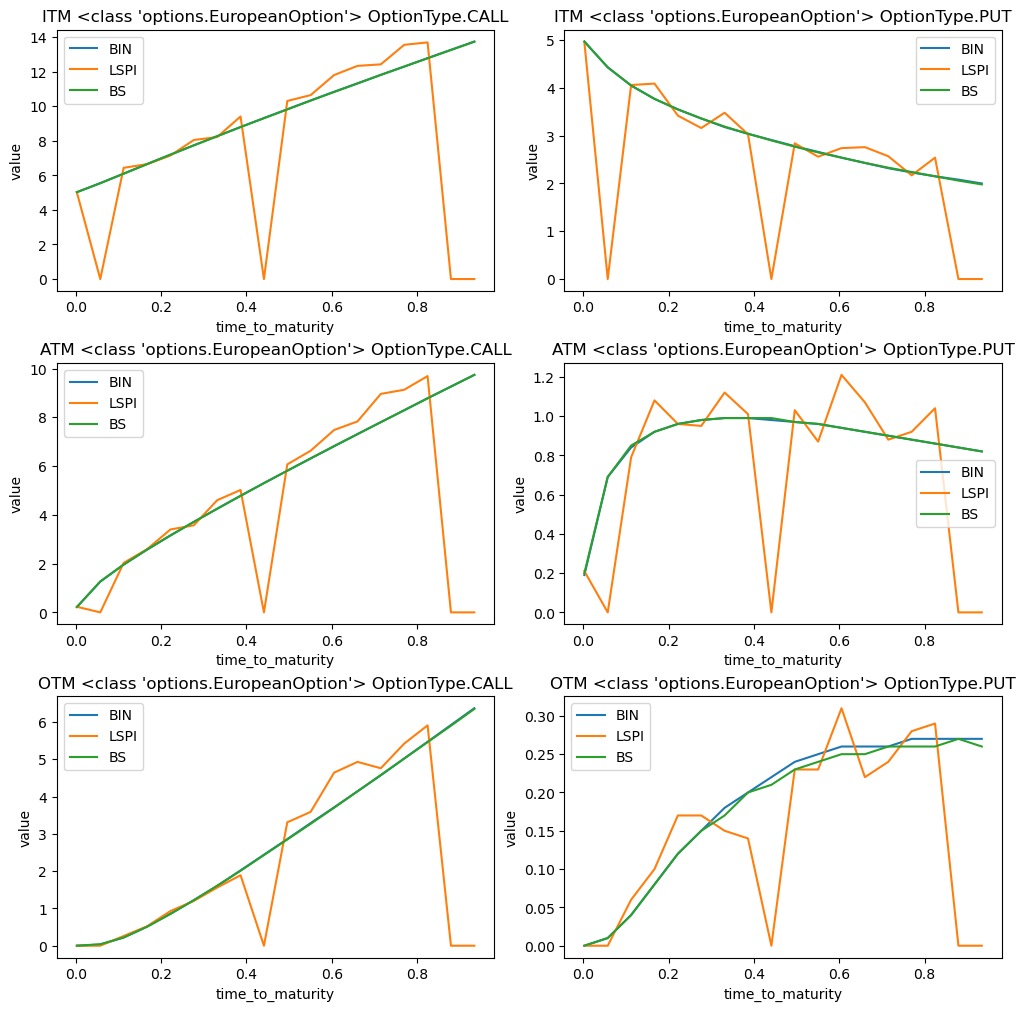

In [6]:
def vary_t(call_options, put_options, t_range=[(1 + 20*j)/365 for j in range(18)]):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=t, num_steps=50) for t in t_range]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=t, num_steps=50) for t in t_range]
            prices = [('BIN', bin_prices), ('LSPI', lspi_prices)]
            if isinstance(option, options.EuropeanOption):
                bs_prices = [black_scholes.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=t)[0] for t in t_range]
                prices.append(('BS', bs_prices))
            plot(ax, prices, t_range, 'time_to_maturity', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_t(call_options, put_options)

### American Options

In [7]:
call_options = {
    "ITM": options.AmericanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.AmericanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.AmericanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ), 
} 

put_options = {
    "ITM": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
}

#### Varying risk-free rate

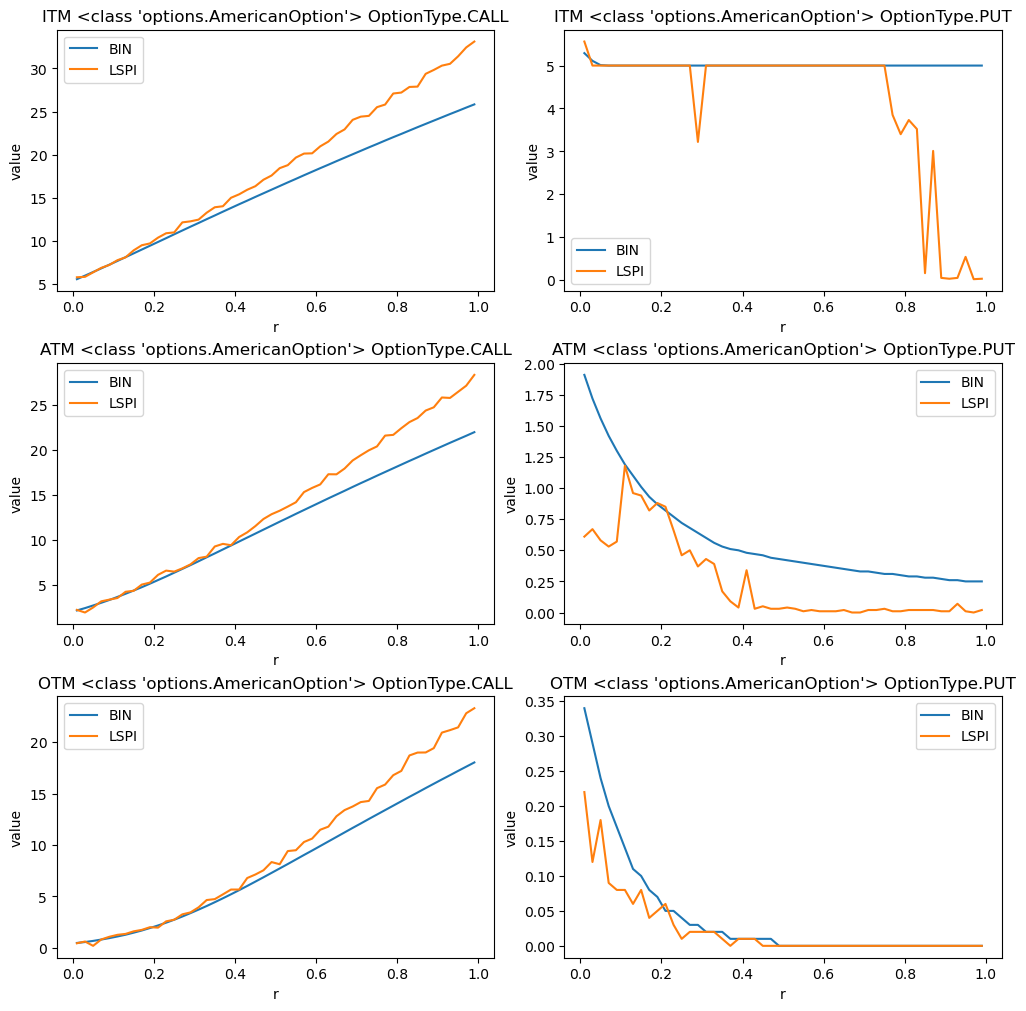

In [8]:
vary_r(call_options, put_options)

Yet again, LSPI values the call options higher than Binomial. As for put options, disregarding the spikes, except for the ATM, the values in other 2 cases seem to match. LSPI does not like ATM put as much as Binomial does.

#### Varying implied volatility

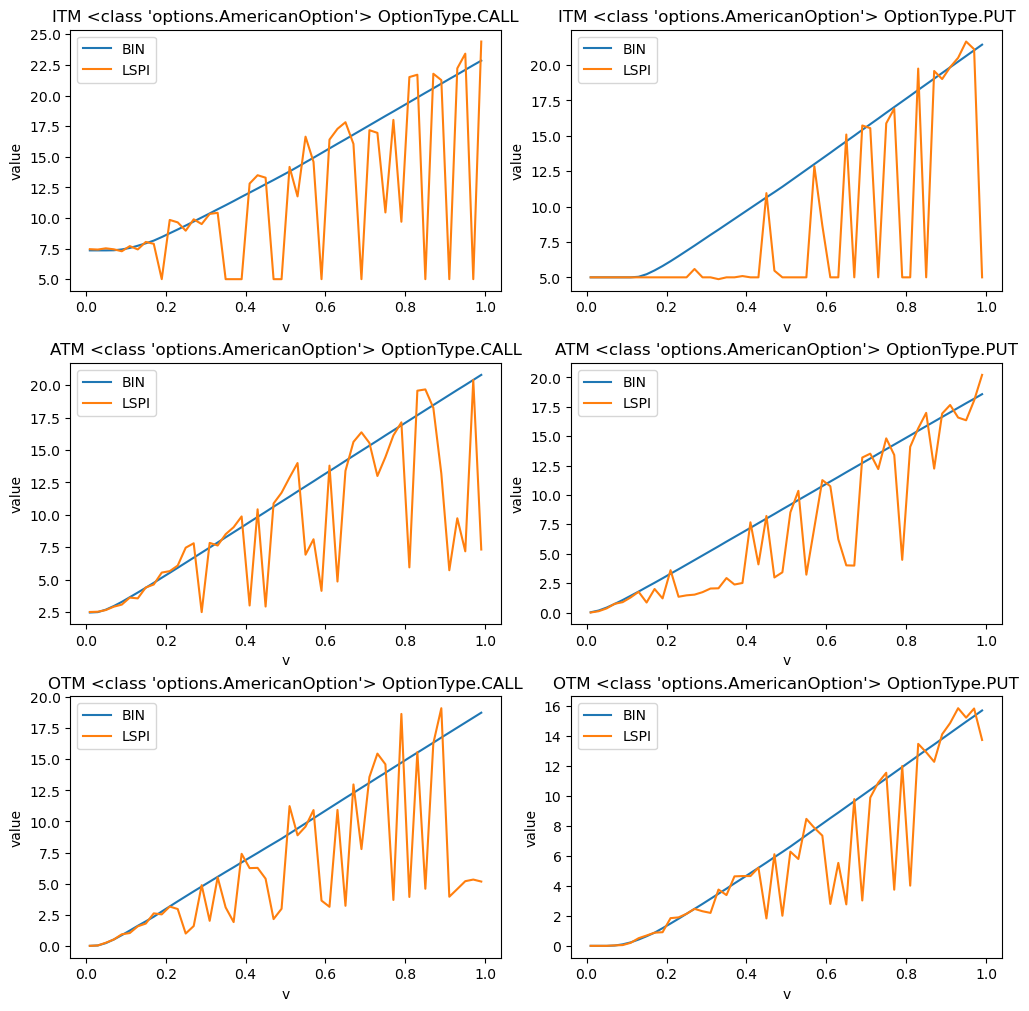

In [9]:
vary_v(call_options, put_options)

We see lot more spikes in LSPI valuations; this is expected as it's a simulation. LSPI more or less agrees with Binomial but there are occassional drops. Need to investigate further, but it might be that sometimes the policy does not converse and we hit maxiter.

#### Varying time to maturity

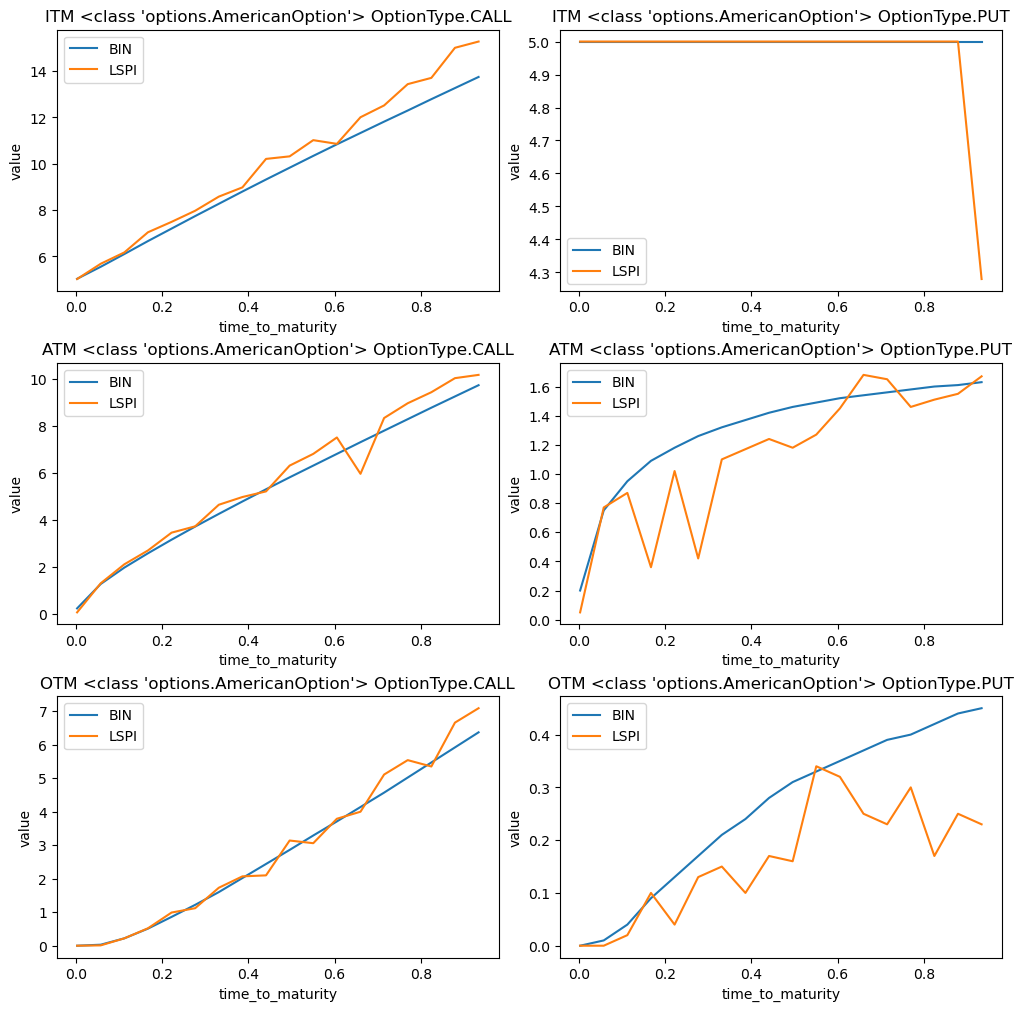

In [10]:
vary_t(call_options, put_options)

### LSPI and Binomial Model

#### Varying number of steps

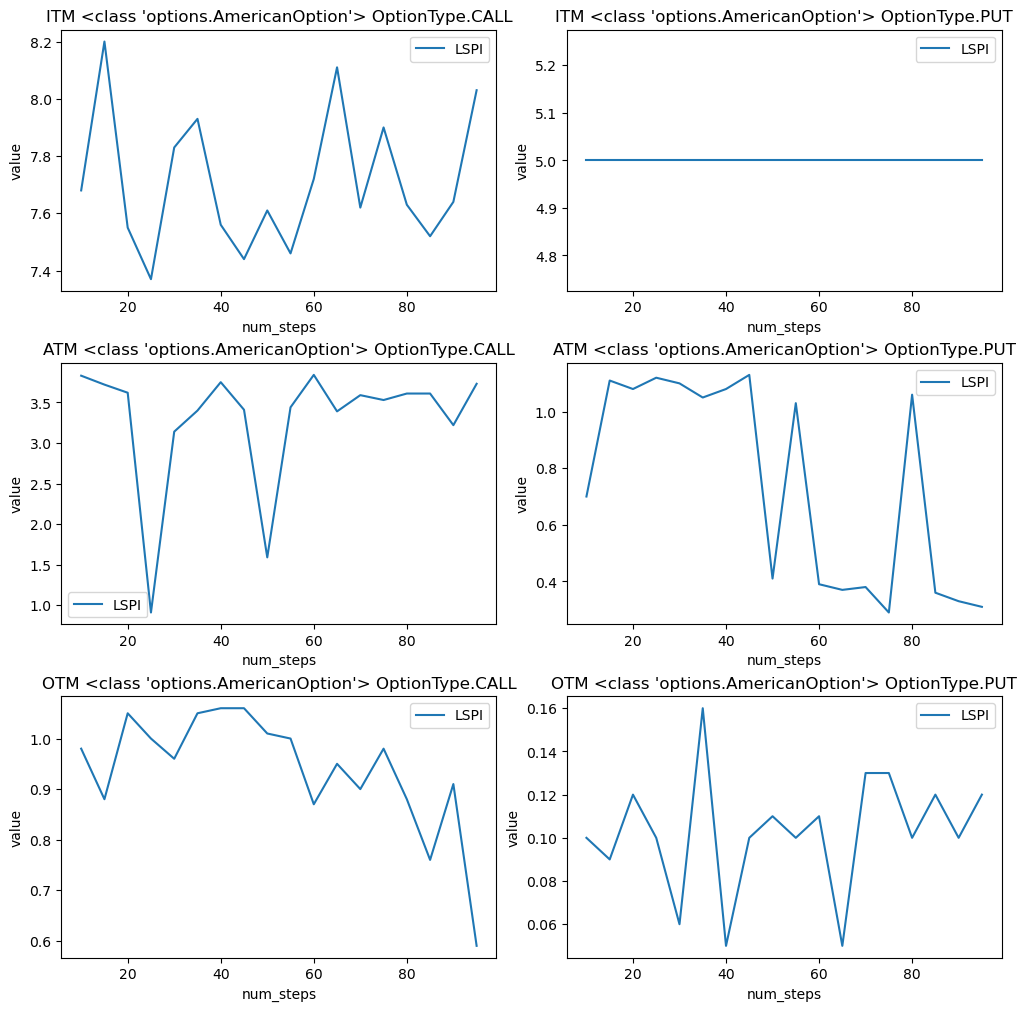

In [11]:
def vary_num_steps(call_options, put_options, num_steps_range=range(10, 100, 5)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps) for num_steps in num_steps_range]
            prices = [('LSPI', lspi_prices)]
            plot(ax, prices, num_steps_range, 'num_steps', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_num_steps(call_options, put_options)

LSPI does not seem to settle on a particular value even when we increase the number of steps. 

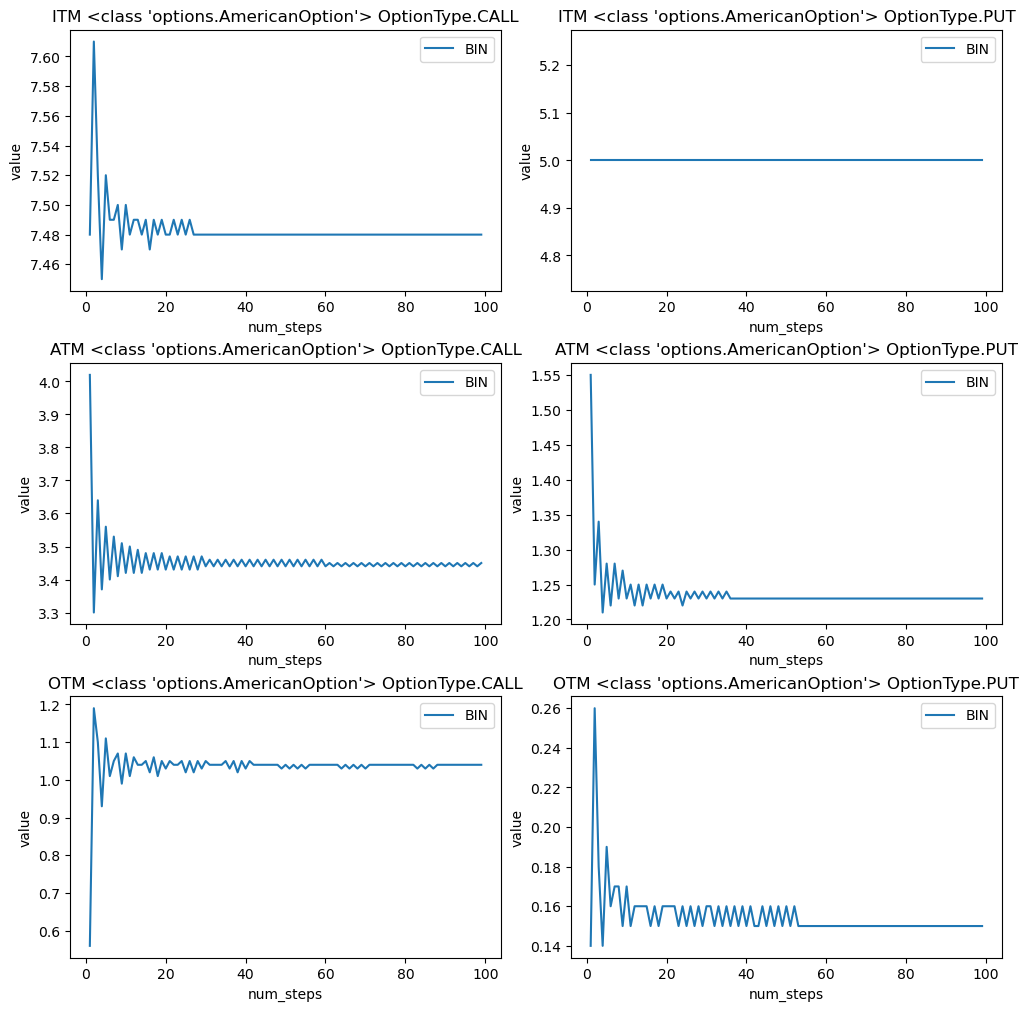

In [12]:
def vary_num_steps_bin(call_options, put_options, num_steps_range=range(1, 100)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps) for num_steps in num_steps_range]
            prices = [('BIN', bin_prices)]
            plot(ax, prices, num_steps_range, 'num_steps', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_num_steps_bin(call_options, put_options)

On the other hand, binomial more or less settles on a value at 20-40 time steps.

#### Varying number of paths

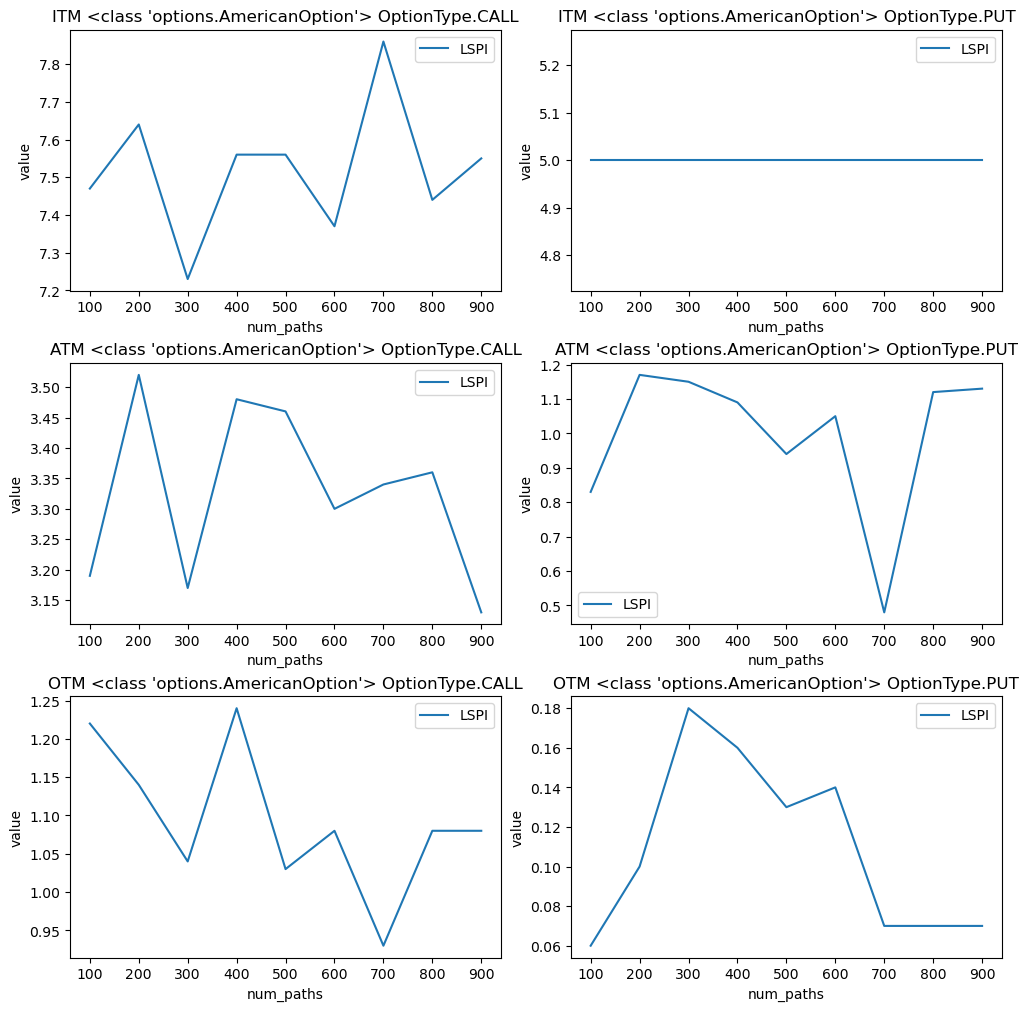

In [13]:
def vary_num_paths(call_options, put_options, num_paths_range=range(100, 1000, 100)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=30, num_paths=num_paths) for num_paths in num_paths_range]
            prices = [('LSPI', lspi_prices)]
            plot(ax, prices, num_paths_range, 'num_paths', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_num_paths(call_options, put_options)

The paper this LSPI impl is based on uses num_steps 662-775 and num_paths 50000. And so it performs better than Longstaff-Schwartz least square method. I do not have such compute power. So we settle for this.

Looking at the algorithm, it's the LSTDQ step that takes the most time. This could potentially be sped up by parallel programming. However, with small num_steps and num_paths, it is faster to run sequentially. 